Original Notebook: https://www.kaggle.com/pourchot/simple-neural-network

## Simple Neural Networks - Modifications

In this notebook, we will evaluate the performance of a slightly modified version of  the Neural Network presented in the notebook https://www.kaggle.com/pourchot/simple-neural-network. Some hyperparameters have been obtained through hyperparameters optimization using Keras Tuner.

In [1]:
# load pycodestyle-magic to be compliant with PEP8 conventions
%load_ext pycodestyle_magic

In [2]:
# activate pycodestyle for each cell
%pycodestyle_on

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import gc
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras import activations,callbacks
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers
from tensorflow.keras.models import Model

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")
targets = pd.get_dummies(train['target'])

In [4]:
cce = tf.keras.losses.CategoricalCrossentropy()
def custom_metric(y_true, y_pred):
    y_pred = K.clip(y_pred, 1e-15, 1-1e-15)
    loss = K.mean(cce(y_true, y_pred))
    return loss

In [5]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_custom_metric',
    min_delta=1e-05,
    patience=8,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True)
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_custom_metric',
    factor=0.7,
    patience=2,
    verbose=0,
    mode='min')

In [6]:
def conv_model():

    conv_inputs = layers.Input(shape=(75))
    # Embedding layers
    embed = layers.Embedding(
        input_dim=354, 
        output_dim=11,
        embeddings_regularizer='l2')(conv_inputs)
    # Convolution layers
    embed = layers.Conv1D(
        10,
        1,
        activation='relu')(embed)
    embed = layers.Flatten()(embed)
    hidden = layers.Dropout(0.3)(embed)
    # Residual blocks layers
    hidden = tfa.layers.WeightNormalization(layers.Dense(
        units=32,
        activation='selu',
        kernel_initializer="lecun_normal"))(hidden)
    hidden2 = layers.Dropout(0.3)(layers.Concatenate()([embed, hidden]))
    hidden2 = tfa.layers.WeightNormalization(
    layers.Dense(
        units=32,
        activation='relu',
        kernel_initializer="lecun_normal"))(hidden2) 
    hidden3 = layers.Dropout(0.4)(layers.Concatenate()([embed, hidden, hidden2]))
    hidden3 = tfa.layers.WeightNormalization(layers.Dense(
        units=32, 
        activation='elu',
        kernel_initializer="lecun_normal"))(hidden3)
    output = layers.Dropout(0.4)(layers.Concatenate()([embed, hidden, hidden2, hidden3]))
    output = tfa.layers.WeightNormalization(layers.Dense(
        units=32, 
        activation='elu',
        kernel_initializer="lecun_normal"))(output)
    # Final layer
    conv_outputs = layers.Dense(
        units=9, 
        activation='softmax',
        kernel_initializer="lecun_normal")(output)
    # Model instantiation
    model = Model(conv_inputs,conv_outputs)
    return model

In [7]:
model = conv_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 75, 11)       3894        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 75, 10)       120         embedding[0][0]                  
__________________________________________________________________________________________________
flatten (Flatten)               (None, 750)          0           conv1d[0][0]                     
______________________________________________________________________________________________

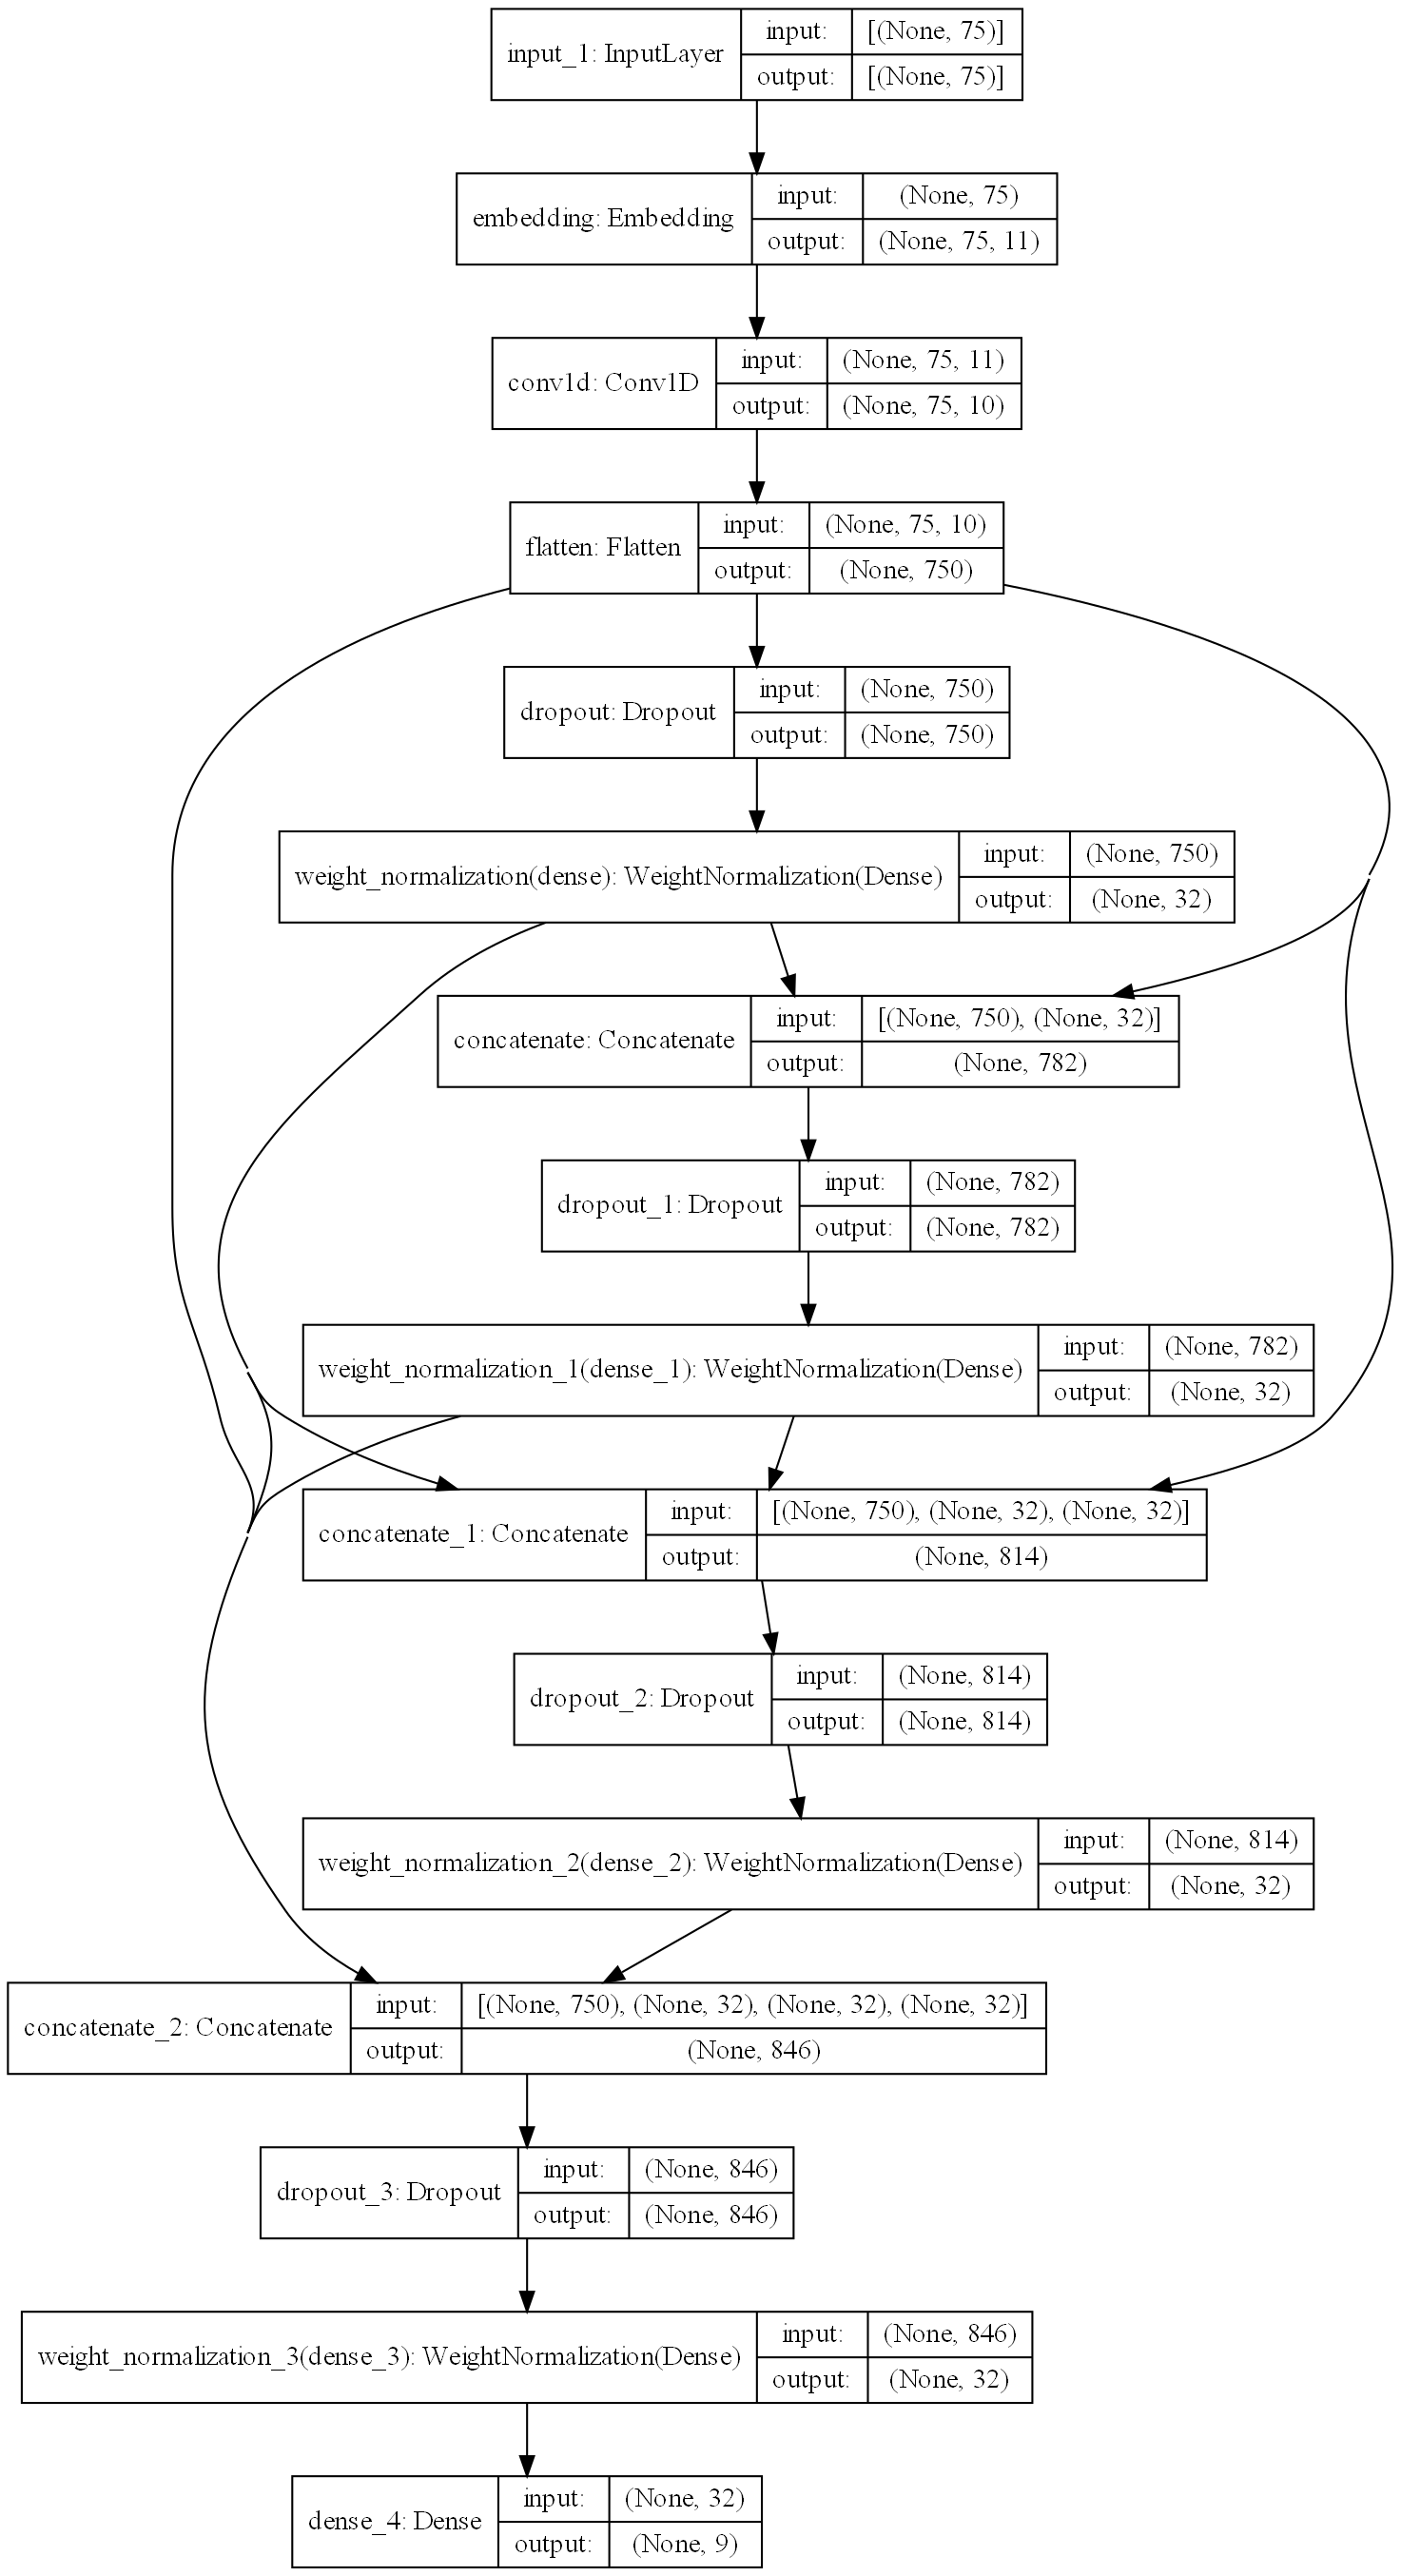

In [8]:
keras.utils.plot_model(
    model, 
    to_file='export_figures/simple_neural_network_adding_dense_and_residual.png', 
    show_shapes=True,
    show_dtype=False,
    rankdir='TB',
    dpi=150)

In [12]:
%%time
oof_NN = np.zeros((train.shape[0], 9))
pred_NN = np.zeros((test.shape[0], 9))
N_FOLDS = 20
SEED = 0
EPOCH = 50
skf = StratifiedKFold(
    n_splits=N_FOLDS, 
    shuffle=True,
    random_state=SEED)
for fold, (tr_idx, ts_idx) in enumerate(skf.split(train, train.iloc[:, -1])):
    print(f"\n ====== TRAINING FOLD {fold} =======\n")
    X_train = train.iloc[:, 1:-1].iloc[tr_idx]
    y_train = targets.iloc[tr_idx]
    X_test = train.iloc[:, 1:-1].iloc[ts_idx]
    y_test = targets.iloc[ts_idx]
    K.clear_session()
    # NN CONV MODEL training
    print("\n-----Convolution model Training----\n")
    model_conv = conv_model()
    model_conv.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
        metrics=custom_metric)
    model_conv.fit(
        X_train,
        y_train,
        batch_size=128,
        epochs=EPOCH,
        validation_data=(X_test, y_test),
        callbacks=[es, plateau],
        verbose=0)
    # Convolution Model prediction
    pred = model_conv.predict(X_test)
    oof_NN[ts_idx] += pred
    score_NN = log_loss(y_test, pred)
    print(f"\nFOLD {fold} Score convolution model: {score_NN}\n")
    pred_NN += model_conv.predict(test.iloc[:, 1:])/N_FOLDS
score = log_loss(targets, oof_NN)
print(f"\n=== FINAL SCORE CONVOLUTION MODEL : {score}===\n")


 ====== TRAINING FOLD 0 =======


-----Convolution model Training----


FOLD 0 Score convolution model: 1.7405213168688118


 ====== TRAINING FOLD 1 =======


-----Convolution model Training----


FOLD 1 Score convolution model: 1.7468096929673105


 ====== TRAINING FOLD 2 =======


-----Convolution model Training----


FOLD 2 Score convolution model: 1.7491459177307784


 ====== TRAINING FOLD 3 =======


-----Convolution model Training----


FOLD 3 Score convolution model: 1.7467767042197286


 ====== TRAINING FOLD 4 =======


-----Convolution model Training----


FOLD 4 Score convolution model: 1.7438694885317236


 ====== TRAINING FOLD 5 =======


-----Convolution model Training----


FOLD 5 Score convolution model: 1.740752454276383


 ====== TRAINING FOLD 6 =======


-----Convolution model Training----


FOLD 6 Score convolution model: 1.7391722238468006


 ====== TRAINING FOLD 7 =======


-----Convolution model Training----


FOLD 7 Score convolution model: 1.7422619148500265




In [13]:
pred_embedding = pred_NN

In [14]:
submission = pd.read_csv("sample_submission.csv")
for i in range(9):
    submission[f'Class_{i+1}'] = pred_embedding[:, i]
submission.to_csv("Purchot_neural_network_v3.csv", index=False)